In [19]:
import os
import imageio.v2 as imageio 
import cv2
import numpy as np

kymo_folder = r"C:\Users\coren\Documents\PostDoc1"
file = os.path.join(kymo_folder,"kymosimple.png")   
kymo = imageio.imread(os.path.join(kymo_folder,file))

In [20]:
def calcGST(inputIMG, w):
    """
    Calculates the Image orientation and the image coherency. Image orientation is merely a guess, and image coherency gives an idea how sure that guess is.
    inputIMG:   The input image
    w:          The window size of the various filters to use. Large boxes catch higher order structures.
    """

    # The idea here is to perceive any patch of the image as a transformation matrix.
    # Such a matrix will have some eigenvalues, which describe the direction of uniform transformation.
    # If the largest eigenvalue is much bigger than the smallest eigenvalue, that indicates a strong orientation.

    img = inputIMG.astype(np.float32)
    imgDiffX = cv2.Sobel(img, cv2.CV_32F, 1, 0, -1)
    imgDiffY = cv2.Sobel(img, cv2.CV_32F, 0, 1, -1)
    imgDiffXY = cv2.multiply(imgDiffX, imgDiffY)
    imgDiffXX = cv2.multiply(imgDiffX, imgDiffX)
    imgDiffYY = cv2.multiply(imgDiffY, imgDiffY)
    J11 = cv2.boxFilter(imgDiffXX, cv2.CV_32F, (w, w))
    J22 = cv2.boxFilter(imgDiffYY, cv2.CV_32F, (w, w))
    J12 = cv2.boxFilter(imgDiffXY, cv2.CV_32F, (w, w))
    tmp1 = J11 + J22
    tmp2 = J11 - J22
    tmp2 = cv2.multiply(tmp2, tmp2)
    tmp3 = cv2.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0 * tmp3)
    lambda1 = 0.5 * (tmp1 + tmp4)  # biggest eigenvalue
    lambda2 = 0.5 * (tmp1 - tmp4)  # smallest eigenvalue
    imgCoherencyOut = cv2.divide(lambda1 - lambda2, lambda1 + lambda2)
    imgOrientationOut = cv2.phase(J22 - J11, 2.0 * J12, angleInDegrees=True)
    imgOrientationOut = 0.5 * imgOrientationOut
    return imgCoherencyOut, imgOrientationOut

def extract_speeds(
    kymo,
    w_size,
    w_start=3,
    C_thresh=0.95,
    blur_size=7,
    C_thresh_falloff=0.002,
    speed_thresh=90,
    preblur=True,
):
    """
    Extract speeds from the kymographs. Will iterate different window sizes to get different particle size velocities
    :param w_size:          Number of window sizes to filter over the kymograph
    :param w_start:         Smallest window size
    :param C_thresh:        Confidence threshold above which to use the extracted orientation
    :param blur_size:       Gaussian window size to use in the blur step of the kymograph
    :param C_thresh_falloff:Value to subtract from C_thresh with each increasing window size
    :param speed_thresh:    Maximum speed to record.
    :param preblur:         Whether to blur the kymograph before extracting speeds
    :param plots:           Deprecated
    :return:                list of array of speeds and time-steps
    """

    """Initialize the speed array and time array"""
    time_pixel_size = 1 #set to the right value
    space_pixel_size = 1 #set to the right value

    """Set up the times axis, should be identical every iteration, also the forward/backward speed arrays"""
    times = np.array(range(kymo.shape[0])) * time_pixel_size
    """Set up speed array for this iteration, also select either forward or backward filtered kymograph"""
    kymo_interest = kymo

    """Preblur gets rid of some gaussian noise in the kymograph"""
    if preblur:
        kymo_interest = cv2.GaussianBlur(
            kymo_interest, (blur_size, blur_size), 0
        )

    """
    imgCoherency is an array with all the coherency and orientations of any given window size,
    imgCoherencySum is meant to document at each pixel which window size provides the highest image coherency
    imgGSTMax is supposed to contain the orientations of the pixels with the highest intensity,
    In the setting up phase, we put nans where the threshold is lower than desired.

    Then in the window iterations, we check for what the max image coherency is, 
    and change the image orientation to that.
    """

    imgCoherency = np.array(
        [
            calcGST(kymo_interest, w)
            for w in range(w_start, w_size * 2 + w_start, 2)
        ]
    )
    imgCoherencySum = 1 * np.greater(imgCoherency[0][0], C_thresh)
    imgCoherencySum = np.where(imgCoherencySum == 1, 0, np.nan)
    imgGSTMax = np.where(imgCoherencySum == 0, imgCoherency[0][1], np.nan)

    for w in range(1, w_size):
        C_thresh_current = C_thresh - C_thresh_falloff * w
        coherency_interest = np.where(
            imgCoherency[w][0] > C_thresh_current,
            imgCoherency[w][0],
            np.nan,
        )
        imgCoherencySum = np.where(
            coherency_interest > imgCoherency[w - 1][0], w, imgCoherencySum
        )
        newValues = np.isnan(imgCoherencySum) * (
            np.invert(np.isnan(coherency_interest))
        )
        imgCoherencySum = np.where(newValues, w, imgCoherencySum)
        imgGSTMax = np.where(
            imgCoherencySum == w, imgCoherency[w][1], imgGSTMax
        )

    """
    The speed is thresholded based on the max speed threshold, and that we don't expect forward speeds in the 
    backwards filtered image and vice versa.
    """

    speed_unthr = (
        np.tan((imgGSTMax - 90) / 180 * np.pi)
        * space_pixel_size
        / time_pixel_size
    )
    speeds = np.where(speed_unthr < speed_thresh, speed_unthr, np.nan)
    speeds = np.where(speeds > -1 * speed_thresh, speeds, np.nan)
    return speeds, times

In [21]:
speeds,times = extract_speeds(kymo,5)

In [28]:
kymo.transpose()

Array([[[ 78,  79,  67, ..., 115, 100,  87],
        [ 84,  86,  77, ..., 120, 117, 108],
        [ 84,  85,  85, ..., 119, 122, 119],
        ...,
        [ 80,  91,  98, ...,  83,  76,  71],
        [ 67,  78,  92, ...,  82,  75,  71],
        [ 70,  80,  94, ...,  89,  81,  77]],

       [[ 78,  79,  67, ..., 115, 100,  87],
        [ 84,  86,  77, ..., 120, 117, 108],
        [ 84,  85,  85, ..., 119, 122, 119],
        ...,
        [ 80,  91,  98, ...,  83,  76,  71],
        [ 67,  78,  92, ...,  82,  75,  71],
        [ 70,  80,  94, ...,  89,  81,  77]],

       [[ 78,  79,  67, ..., 115, 100,  87],
        [ 84,  86,  77, ..., 120, 117, 108],
        [ 84,  85,  85, ..., 119, 122, 119],
        ...,
        [ 80,  91,  98, ...,  83,  76,  71],
        [ 67,  78,  92, ...,  82,  75,  71],
        [ 70,  80,  94, ...,  89,  81,  77]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ..

C:\Users\coren\AppData\Local\Temp\ipykernel_28320\2909969118.py:5: RuntimeWarning: Mean of empty slice
  ax2.plot(np.nanmean(speeds,axis=1),times)


(-2.0, 2.0)

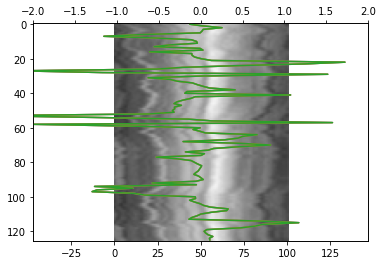

In [35]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax2 =ax.twiny()
ax.imshow(kymo)
ax2.plot(np.nanmean(speeds,axis=1),times)
ax2.set_xlim(-2,2)